In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '.')

### Conexão com o banco de dados

In [2]:
class DbConn:

    def __init__(self) -> None:
        self.conn = sqlite3.connect("../data/latest.db") 

    def execute_sql(self, query:str, params:dict = None, return_df:bool = True): 

        cur = self.conn.cursor() 
        try:
            if params is not None:
                cur.execute(query, params) 
            else:
                cur.execute(query) 
            if return_df:
                column_names = [col[0] for col in cur.description] 
                query_data = cur.fetchall() 
                query_df = pd.DataFrame.from_records(query_data, columns=column_names) 
                res = query_df 

            return res 
        finally:
            cur.close() 

    def commit(self):
        self.conn.commit() 
        self.conn.close() 

def getLvl1Data():
    
    conn = DbConn()

    query = f"""
            SELECT t.*,
                l.administrative_area_level,
                l.administrative_area_level_1,
                l.administrative_area_level_2,
                l.administrative_area_level_3,
                l.latitude,
                l.longitude,
                l.population
            FROM timeseries t 
            LEFT JOIN location l on l.id = t.id
            WHERE l.administrative_area_level = 1;
            """ 
    
    df = conn.execute_sql(query=query, return_df=True)  

    # Convert date column to datetime and get the date 
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
    df['date'] = df['date'].apply(lambda x: pd.Timestamp(x).date())

    return df

def getLvl2Data():
    
    conn = DbConn()

    query = f"""
            SELECT t.*,
                l.administrative_area_level,
                l.administrative_area_level_1,
                l.administrative_area_level_2,
                l.administrative_area_level_3,
                l.latitude,
                l.longitude,
                l.population
            FROM timeseries t 
            LEFT JOIN location l on l.id = t.id
            WHERE l.administrative_area_level = 2;
            """ 
    
    df = conn.execute_sql(query=query, return_df=True)  
    # Convert date column to datetime and get the date 
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
    df['date'] = df['date'].apply(lambda x: pd.Timestamp(x).date())

    st.session_state['downloaded_lvl2_data'] = True

    return df


### Funções Auxiliares

In [3]:
def epidemiological_features():
    epidemiological_features = ['confirmed', 'deaths', 'recovered', 'tests', 'vaccines', 'people_vaccinated', 'people_fully_vaccinated', 'hosp']
    return epidemiological_features 
    
def get_feature_time_series_lvl_1(df:pd.DataFrame, feature:str, administrative_area_level_1:str):

    epidemiological_features = ['confirmed', 'deaths', 'recovered', 'tests', 'vaccines', 'people_vaccinated', 'people_fully_vaccinated', 'hosp']

    df = df.query('administrative_area_level == 1 and administrative_area_level_1 == @administrative_area_level_1')

    df = df[['date', feature]] 

    df['date'] = pd.to_datetime(df['date'])

    df = df.set_index('date')

    try:
        if df[feature].isnull().value_counts().iloc[1] > 0:
            df[feature] = df[feature].fillna(0) 

            return df 
    finally:
        return df 

def get_feature_time_series_lvl_2(df:pd.DataFrame, feature:str, administrative_area_level_2:str):

    epidemiological_features = ['confirmed', 'deaths', 'recovered', 'tests', 'vaccines', 'people_vaccinated', 'people_fully_vaccinated', 'hosp']

    df = df.query('administrative_area_level == 2 and administrative_area_level_2 == @administrative_area_level_2')

    df = df[['date', feature]] 

    df = df.set_index('date')

    try:
        if df[feature].isnull().value_counts().iloc[1] > 0:
            df[feature] = df[feature].fillna(0) 

            return df 
    finally:
        return df  

def get_feature_time_series_lvl_3(df:pd.DataFrame, feature:str, administrative_area_level_3:str):

    epidemiological_features = ['confirmed', 'deaths', 'recovered', 'tests', 'vaccines', 'people_vaccinated', 'people_fully_vaccinated', 'hosp']

    df = df.query('administrative_area_level == 3 and administrative_area_level_3 == @administrative_area_level_3')

    df = df[['date', feature]] 

    df = df.set_index('date')


    try:
        if df[feature].isnull().value_counts().iloc[1] > 0:
            df[feature] = df[feature].fillna(0) 

            return df 
    finally:
        return df 

In [4]:
df = getLvl1Data()

In [5]:
br_confirmed = get_feature_time_series_lvl_1(df, feature='confirmed', administrative_area_level_1='Brazil')
br_confirmed.reset_index(inplace=True)

In [6]:
plt.rc('axes', titlesize='medium')
plt.rc('axes', titlelocation='left')
plt.rc('axes.spines', right=False)
plt.rc('axes.spines', top=False)
sizets = (8,6)
plt.rc('figure', figsize=sizets)

In [7]:
def plot_time_series(df:pd.DataFrame):
    
    feature = df.columns[0].title()

    ax = df.iloc[:,0].plot(figsize=sizets)
    plt.suptitle('Cumulative Confirmed')
    ax.set(ylabel=f'{feature}', title='Test')
    ax.grid() 

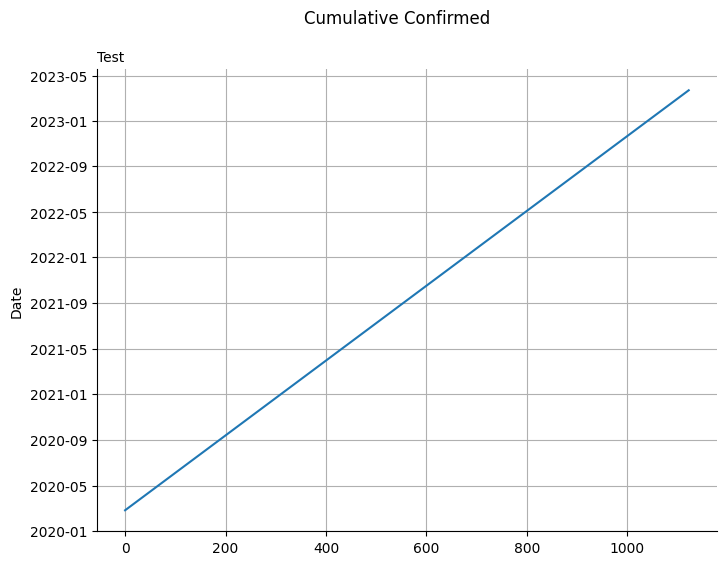

In [8]:
plot_time_series(br_confirmed)

### Resample Time-Series

In [9]:
def resample_time_series(data_frame, time_column, value_column, time_window):
    """
    Resample a time series DataFrame based on the desired time window.

    Parameters:
    - data_frame (pd.DataFrame): DataFrame containing the time series data.
    - time_column (str): Name of the column containing time information.
    - value_column (str): Name of the column containing the values.
    - time_window (str): Pandas offset alias for the desired time window
                        ('D' for daily, 'W' for weekly, 'M' for monthly, etc.).

    Returns:
    - pd.DataFrame: Resampled time series DataFrame.
    """

    df = data_frame.copy()

    # Ensure the time column is in datetime format
    df[time_column] = pd.to_datetime(df[time_column])

    # Set the time column as the DataFrame index
    df.set_index(time_column, inplace=True)

    # Resample the time series based on the specified time window
    resampled_df = df[value_column].resample(time_window).sum()

    # Convert the index to a column named 'date' and reset the index
    resampled_df = pd.DataFrame(resampled_df)
    resampled_df.reset_index(inplace=True)
    # resampled_df['date'] = pd.to_numeric(pd.to_datetime(resampled_df[time_column]))

    return resampled_df

In [10]:
monthly_df = resample_time_series(br_confirmed, time_column='date', value_column='confirmed', time_window='M')
weekly_df = resample_time_series(br_confirmed, time_column='date', value_column='confirmed', time_window='W')
yearly_df = resample_time_series(br_confirmed, time_column='date', value_column='confirmed', time_window='Y')

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

def difference_time_series(time_series, lags=1):
    """
    Perform differencing on a time series.

    Parameters:
    - time_series (pd.Series): Time series to be differenced.
    - lags (int): Number of lags for differencing (default is 1).

    Returns:
    - pd.Series: Differenced time series.
    """
    return time_series.diff(lags).dropna()

def test_stationarity(time_series):
    """
    Test the stationarity of a time series using the Augmented Dickey-Fuller test.

    Parameters:
    - time_series (pd.Series): Time series to be tested for stationarity.

    Returns:
    - None
    """
    result = adfuller(time_series)
    p_value = result[1]

    # Print ADF test results
    print(f'Augmented Dickey-Fuller Test Results:')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {p_value}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')

    if p_value <= 0.05:
        print('\nThe time series is likely stationary based on the ADF test.')
    else:
        print('\nThe time series is likely non-stationary based on the ADF test.')

def plot_decomposition(time_series, lags=1, model:str = ['additive', 'multiplicative']):
    """
    Plot the decomposed series of a differenced time series.

    Parameters:
    - time_series (pd.Series): Differenced time series to be decomposed.
    - lags (int): Number of lags for differencing (default is 1).
    - model (str): Decomposition method: 'additive' or 'multiplicative'.

    Returns:
    - None
    """
    # Perform seasonal decomposition
    decomposition = seasonal_decompose(time_series, model='multiplicative')

    plt.figure(figsize=(12, 8))

    plt.subplot(4, 1, 1)
    plt.plot(time_series, label='Original Series')
    plt.title('Original Time Series')

    plt.subplot(4, 1, 2)
    plt.plot(difference_time_series(time_series, lags=lags), label=f'Differenced Series (lags={lags})')
    plt.title('Differenced Time Series')

    plt.subplot(4, 1, 3)
    plt.plot(decomposition.trend, label='Trend')
    plt.title('Trend Component')

    plt.subplot(4, 1, 4)
    plt.plot(decomposition.resid, label='Residuals')
    plt.title('Residual Component')

    plt.tight_layout()
    plt.show()

### Modelagem

In [12]:
confirmados = br_confirmed.copy() 
confirmados['confirmed'] = confirmados['confirmed'].diff() 
confirmados.rename(columns={"confirmed":"confirmados_diario"}, inplace=True)
confirmados['confirmados_diario'].fillna(0, inplace=True)

In [13]:
confirmados['diff_01'] = confirmados['confirmados_diario'].diff().fillna(0)
confirmados['diff_01_and_diff_07'] = confirmados['diff_01'].diff(7).fillna(0)

In [225]:
confirmados['stationary'] = confirmados['confirmados_diario'].diff(1).diff(7)

#### Invertendo Transformações

Está no notebook

### Train/Test Split

In [226]:
def train_test_split(stationary_ts, proportion=80):
    train_size = int((proportion/100)*len(stationary_ts))
    train, test = stationary_ts[:train_size], stationary_ts[train_size:]

    print(train_size)

    return train, test

In [227]:
train, test = train_test_split(confirmados, proportion=80)

898


In [228]:
train

,date,confirmados_diario,diff_01,diff_01_and_diff_07,stationary
0,2020-02-25,0.0,0.0,0.0,NaN
1,2020-02-26,0.0,0.0,0.0,NaN
2,2020-02-27,0.0,0.0,0.0,NaN
3,2020-02-28,1.0,1.0,0.0,NaN
4,2020-02-29,0.0,-1.0,0.0,NaN
...,...,...,...,...,...
893,2022-08-06,16703.0,-13273.0,5551.0,5551.0
894,2022-08-07,7198.0,-9505.0,-6929.0,-6929.0
895,2022-08-08,17409.0,10211.0,8460.0,8460.0
896,2022-08-09,30220.0,12811.0,411.0,411.0


### Modelo AR

In [231]:
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

# Build AR model
selector = ar_select_order(train['stationary'].fillna(0), 20)
model = AutoReg(train['stationary'].fillna(0), lags=selector.ar_lags).fit()

In [232]:
# Get bforecasts and convert to actual
transformed_forecasts = list(model.forecast(steps=len(test))) 

original_scale_forecasts = pd.Series(transformed_forecasts).cumsum().cumsum()
# reverse_diff1 = reverse_diff7.diff(1) 
# original_scale_forecasts = reverse_diff1.add(confirmados['confirmados_diario'].iloc[-1])

In [236]:
original_scale_forecasts

0       -4448.369050
1       -5075.433027
2       -9855.841989
3      -13236.285844
4      -15045.289771
           ...      
220   -862526.792817
221   -867163.623452
222   -871807.066598
223   -876457.120565
224   -881113.786088
Length: 225, dtype: float64

In [235]:
import plotly.graph_objects as go 

def plot_forecasts(forecasts: list[float],
                   title: str) -> None:
    """Function to plot the forecasts."""
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=train['date'], y=train['confirmados_diario'], name='Train'))
    fig.add_trace(go.Scatter(x=test['date'], y=test['confirmados_diario'], name='Test'))
    fig.add_trace(go.Scatter(x=test['date'], y=forecasts, name='Forecast'))
    fig.update_layout(template="simple_white", font=dict(size=18), title_text=title,
                      width=650, title_x=0.5, height=400, xaxis_title='Date',
                      yaxis_title='Casos Confirmados')

    return fig.show()


# Plot the forecasts
plot_forecasts(original_scale_forecasts, 'Autoregression')

### Testando Diferenciacao

In [21]:
import os 
from statsforecast import StatsForecast 
from statsforecast.models import AutoARIMA

c:\Users\heito\OneDrive\Documentos\Estudos\becd\07sem\SME0808 - series-temporais\time-series\.venv\lib\site-packages\statsforecast\core.py:25: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



In [25]:
br_confirmed.insert(0, column="unique_id", value="Confirmados_BR")

In [35]:
statsforecast_df = br_confirmed.copy()

statsforecast_df.rename(columns={"date":"ds", "confirmed":"y"}, inplace=True)

In [37]:
statsforecast_df['y'] = statsforecast_df['y'].diff()

In [39]:
statsforecast_df['y'] = statsforecast_df['y'].fillna(0)

### StatsForecast Modelling

In [42]:
os.environ['NIXTLA_ID_AS_COL'] = '1'

In [265]:
sf = StatsForecast(
    models=[AutoARIMA(season_length=7)],
    freq='D',
) 

sf.fit(statsforecast_df)

StatsForecast(models=[AutoARIMA])

In [268]:
forecast_df = sf.predict(h=90, level=[95]) 

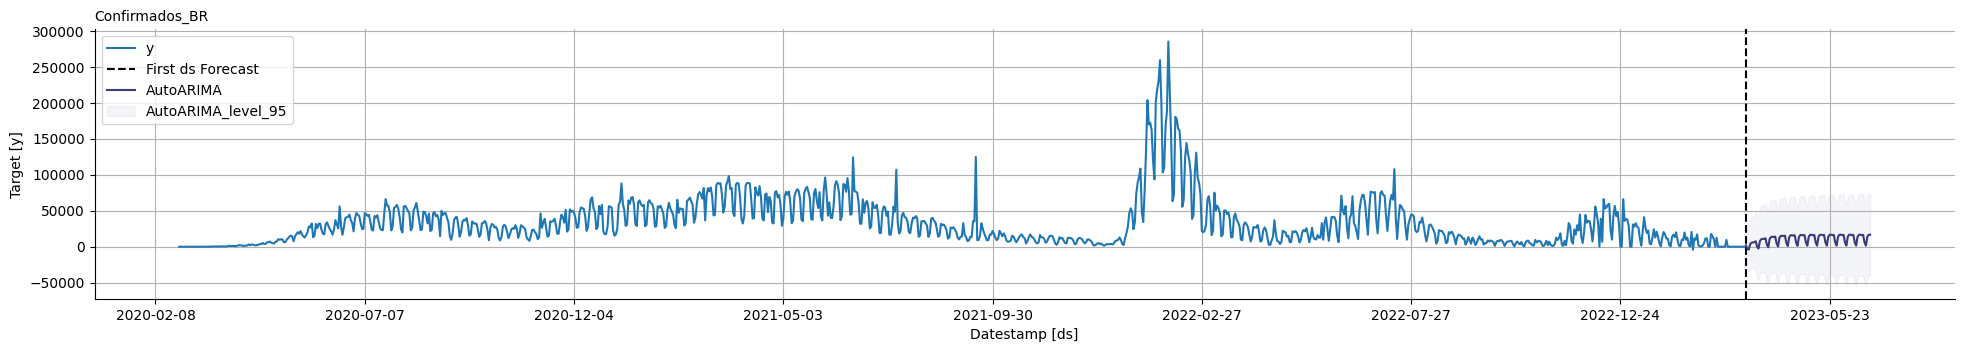

In [269]:
sf.plot(statsforecast_df, forecast_df, level=[95])

### AR Model

In [51]:
def train_test_split(df, proportion):

    train_size = int((proportion/100)*len(df))
    train, test = df[:train_size], df[train_size:] 

    return train, test 

In [429]:
train_sf, test_sf = train_test_split(statsforecast_df, 80)

898


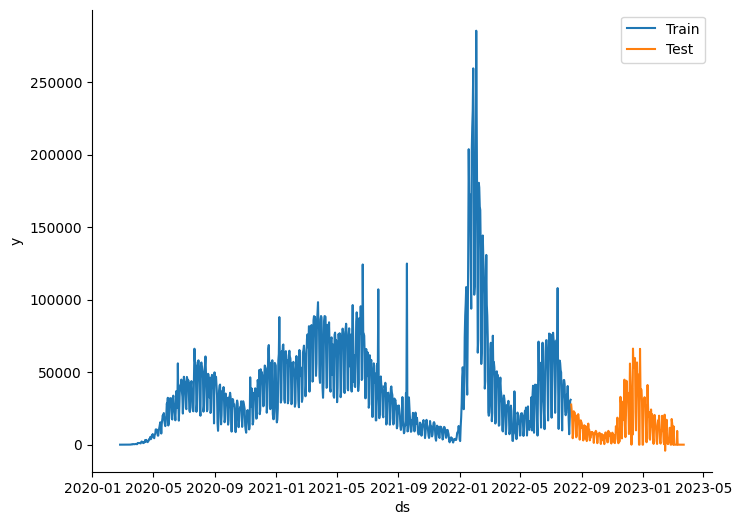

In [55]:
import seaborn as sns 

sns.lineplot(train_sf,x="ds", y="y", label="Train")
sns.lineplot(test_sf, x="ds", y="y", label="Test")
plt.show()

In [370]:
from statsforecast.models import AutoRegressive 

season_length = 7 
horizon=len(test_sf) 

models = [AutoRegressive(lags=[20],include_mean=False)]

In [371]:
sf = StatsForecast(
    df = train_sf,
    models=models,
    freq='D',
    n_jobs=-1
)

In [372]:
sf.fit()

c:\Users\heito\OneDrive\Documentos\Estudos\becd\07sem\SME0808 - series-temporais\time-series\.venv\lib\site-packages\statsforecast\arima.py:828: UserWarning:

some AR parameters were fixed: setting transform_pars = False



StatsForecast(models=[AutoRegressive])

In [373]:
Y_hat = sf.forecast(horizon, fitted=True)

In [374]:
values = sf.forecast_fitted_values() 
values.head()

,ds,y,AutoRegressive
unique_id,,,
Confirmados_BR,2020-02-25,0.0,0.000000
Confirmados_BR,2020-02-26,0.0,0.000000
Confirmados_BR,2020-02-27,0.0,0.000000
Confirmados_BR,2020-02-28,1.0,0.365047
Confirmados_BR,2020-02-29,0.0,0.000000


In [375]:
Y_hat=Y_hat.reset_index()

In [376]:
Y_hat1 = test_sf.merge(Y_hat, how='left', on=['unique_id', 'ds'])

In [377]:
Y_hat1

,unique_id,ds,y,AutoRegressive
0,Confirmados_BR,2022-08-11,27644.0,38472.261719
1,Confirmados_BR,2022-08-12,23552.0,20091.730469
2,Confirmados_BR,2022-08-13,17726.0,7588.767578
3,Confirmados_BR,2022-08-14,4429.0,23647.009766
4,Confirmados_BR,2022-08-15,7954.0,29290.494141
...,...,...,...,...
220,Confirmados_BR,2023-03-19,0.0,2250.846436
221,Confirmados_BR,2023-03-20,0.0,1175.480713
222,Confirmados_BR,2023-03-21,0.0,443.986145
223,Confirmados_BR,2023-03-22,0.0,1383.484863


<Axes: >

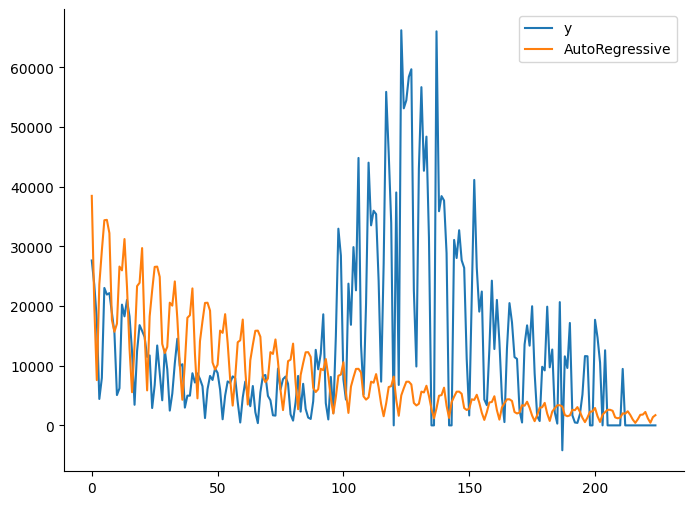

In [378]:
Y_hat1.iloc[:,[2,3]].plot()

## Differenciacao com Sklearn

In [200]:
from skforecast.preprocessing import TimeSeriesDifferentiator

differentiator_1 = TimeSeriesDifferentiator(order=1)
differentiator_2 = TimeSeriesDifferentiator(order=1)
differentiator_7 = TimeSeriesDifferentiator(order=7)

In [199]:
first_difference = differentiator_1.transform(br_confirmed['confirmed'])
second_difference = differentiator_2.transform(first_difference)
third_difference = differentiator_7.transform(second_difference)

In [ ]:
first_undiff = differentiator_1.inverse_transform(first_difference)
second_undiff = differentiator_2.inverse_transform(second_difference)
third_undiff = differentiator_7.inverse_transform(third_difference) 
# third_undiff = pd.Series(third_difference).expanding().sum()

In [211]:
import pandas as pd

def revert_transformations(series):

    return pd.Series(series).cumsum().cumsum()

# Apply the transformations
transformed_series = br_confirmed['confirmed'].diff(1).diff(7)

# Revert the transformations
reverted_series = revert_transformations(transformed_series)


<Axes: >

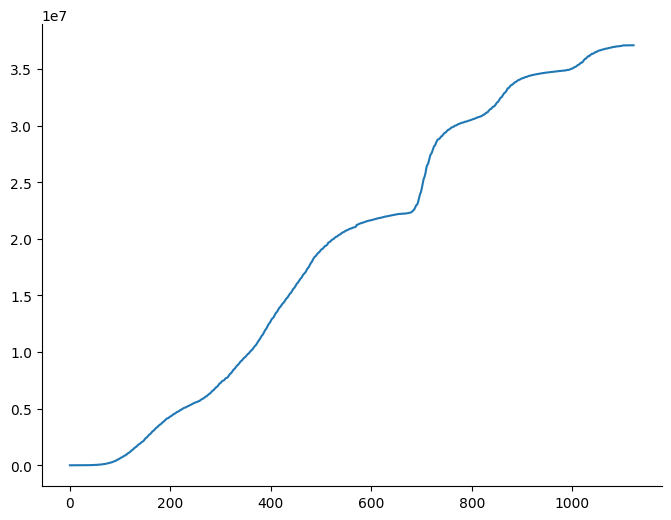

In [212]:
br_confirmed['confirmed'].plot()

<Axes: >

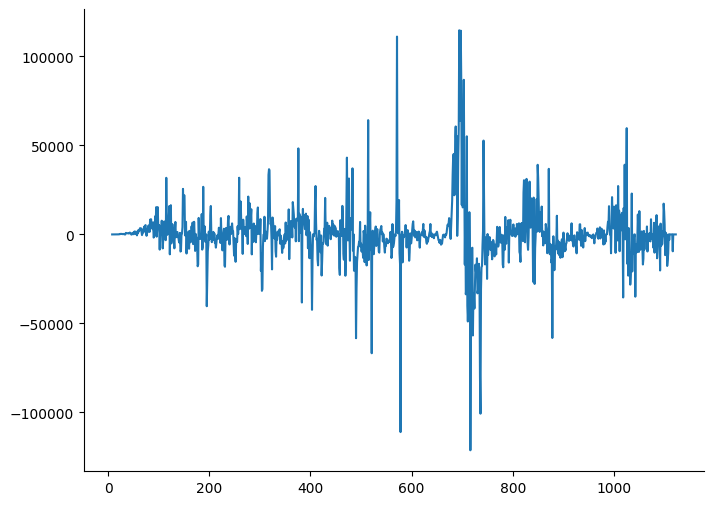

In [213]:
transformed_series.plot()

<Axes: >

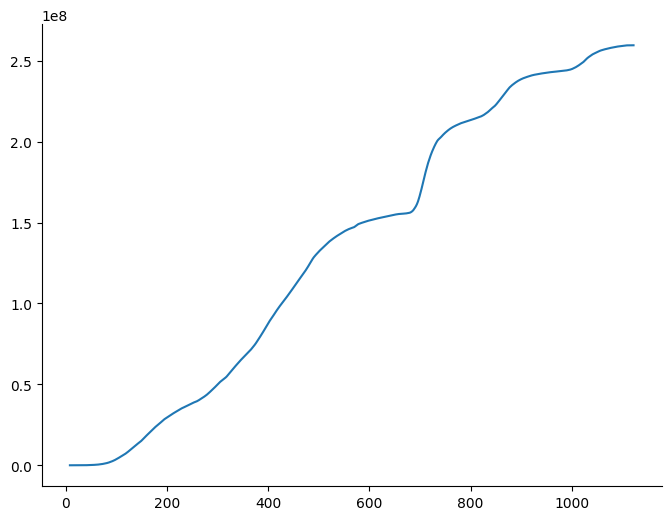

In [217]:
pd.Series(transformed_series.cumsum().cumsum()).plot()

### ARIMA StatsForecast

In [254]:
series = pd.DataFrame(first_difference, columns=['serie'])
detrended_series =  series['serie'].diff() 
detrended_series = pd.DataFrame(detrended_series.values, columns=['y']) 
detrended_series['unique_id'] = '1' 
detrended_series['ds'] = br_confirmed['date']

In [255]:
detrended_series

,y,unique_id,ds
0,NaN,1,2020-02-25
1,NaN,1,2020-02-26
2,0.0,1,2020-02-27
3,1.0,1,2020-02-28
4,-1.0,1,2020-02-29
...,...,...,...
1118,0.0,1,2023-03-19
1119,0.0,1,2023-03-20
1120,0.0,1,2023-03-21
1121,0.0,1,2023-03-22


In [256]:
from statsforecast.models import ARIMA 

arima = ARIMA(order=(7,7,7), season_length=7) 

arima = arima.fit(y=detrended_series['y'].values)

In [257]:
y_hat_dict = arima.predict(h=30)
y_hat_dict

{'mean': array([2.86533101e-11, 1.98754181e-10, 7.89559756e-10, 2.35594634e-09,
        5.86440000e-09, 1.28558415e-08, 2.56352854e-08, 4.74883339e-08,
        8.29245043e-08, 1.37947392e-07, 2.20351665e-07, 3.40046898e-07,
        5.09408235e-07, 7.43653889e-07, 1.06124948e-06, 1.48433919e-06,
        2.03920378e-06, 2.75674543e-06, 3.67299940e-06, 4.82967251e-06,
        6.27470855e-06, 8.06288038e-06, 1.02564090e-05, 1.29256093e-05,
        1.61495628e-05, 2.00168173e-05, 2.46261130e-05, 3.00871357e-05,
        3.65212969e-05, 4.40625406e-05])}

In [258]:
y_hat_df = arima.forecast(y=detrended_series["y"].values, h = 30, fitted=True) 
y_hat_df

{'mean': array([2.86533101e-11, 1.98754181e-10, 7.89559756e-10, 2.35594634e-09,
        5.86440000e-09, 1.28558415e-08, 2.56352854e-08, 4.74883339e-08,
        8.29245043e-08, 1.37947392e-07, 2.20351665e-07, 3.40046898e-07,
        5.09408235e-07, 7.43653889e-07, 1.06124948e-06, 1.48433919e-06,
        2.03920378e-06, 2.75674543e-06, 3.67299940e-06, 4.82967251e-06,
        6.27470855e-06, 8.06288038e-06, 1.02564090e-05, 1.29256093e-05,
        1.61495628e-05, 2.00168173e-05, 2.46261130e-05, 3.00871357e-05,
        3.65212969e-05, 4.40625406e-05]),
 'fitted': array([            nan,             nan,  0.00000000e+00, ...,
        -3.29414722e-09,  1.39116002e-09, -2.53922289e-10])}

In [259]:
detrended_series

,y,unique_id,ds
0,NaN,1,2020-02-25
1,NaN,1,2020-02-26
2,0.0,1,2020-02-27
3,1.0,1,2020-02-28
4,-1.0,1,2020-02-29
...,...,...,...
1118,0.0,1,2023-03-19
1119,0.0,1,2023-03-20
1120,0.0,1,2023-03-21
1121,0.0,1,2023-03-22


In [430]:
train['stationary'] = train['stationary'].fillna(0)

C:\Users\heito\AppData\Local\Temp\ipykernel_8164\2335041848.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [433]:
# Build AR model
selector = ar_select_order(train['stationary'], 15)
model = AutoReg(train['stationary'], lags=selector.ar_lags).fit()

In [434]:
forecasts = list(model.forecast(steps=len(test)))

In [435]:
test['forecast'] = forecasts

C:\Users\heito\AppData\Local\Temp\ipykernel_8164\4175789550.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<Axes: >

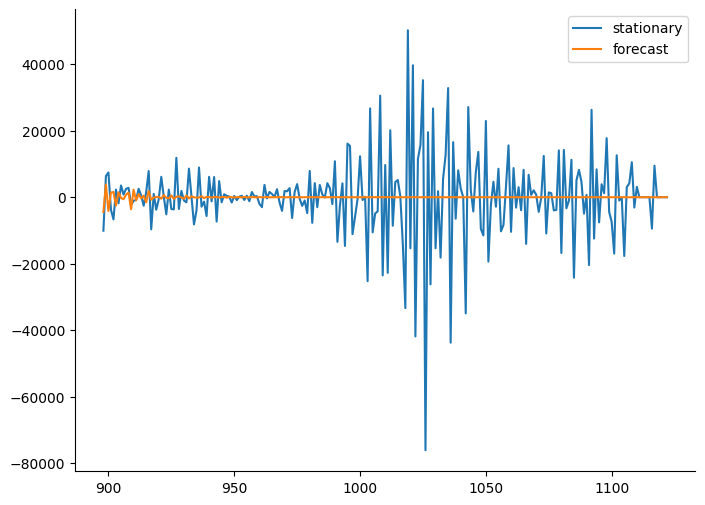

In [437]:
test[['stationary', 'forecast']].plot()

In [439]:
test['forecast_original'] = test['forecast'].cumsum().cumsum()

C:\Users\heito\AppData\Local\Temp\ipykernel_8164\1157129422.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [385]:
transformed_forecasts = pd.Series(forecasts).cumsum().cumsum()

## MA Model

In [416]:
# Import packages
from statsmodels.tsa.arima.model import ARIMA

# Train model
model = ARIMA(train['stationary'], order=(14, 1, 30)).fit()

c:\Users\heito\OneDrive\Documentos\Estudos\becd\07sem\SME0808 - series-temporais\time-series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

c:\Users\heito\OneDrive\Documentos\Estudos\becd\07sem\SME0808 - series-temporais\time-series\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [417]:
ma_forecasts = list(model.forecast(steps=len(test)))

In [418]:
test['ma_forecast'] = ma_forecasts

C:\Users\heito\AppData\Local\Temp\ipykernel_8164\3327007173.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<Axes: >

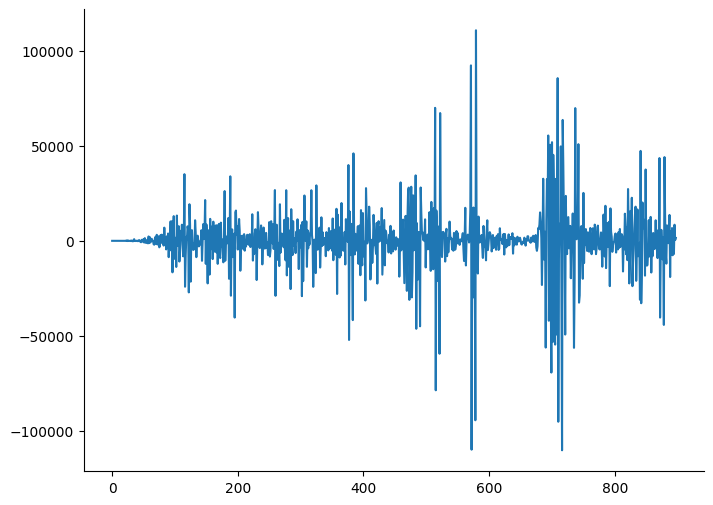

In [419]:
train['stationary'].plot()

<Axes: >

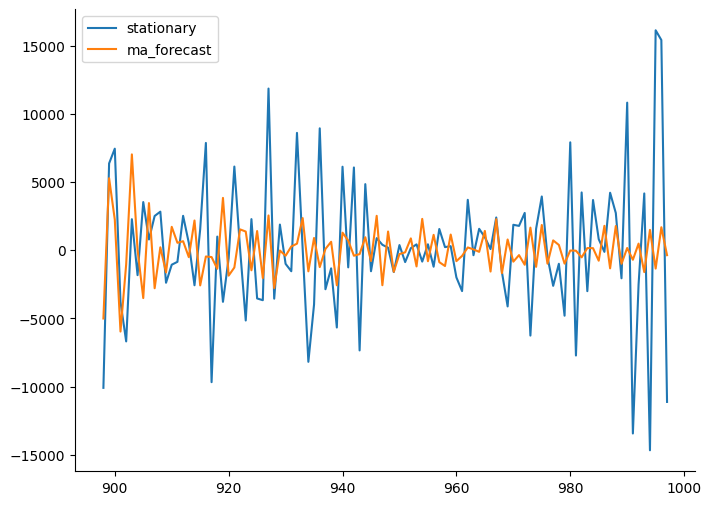

In [428]:
test[['stationary', 'ma_forecast']].iloc[:100,:].plot()